# 1. Install Dependencies and Setup

In [1]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
!pip list

Package                            Version
---------------------------------- --------------------
absl-py                            1.4.0
accelerate                         1.1.1
aiohappyeyeballs                   2.4.3
aiohttp                            3.11.1
aiosignal                          1.3.1
alabaster                          1.0.0
albucore                           0.0.19
albumentations                     1.4.20
altair                             4.2.2
annotated-types                    0.7.0
anyio                              3.7.1
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
array_record                       0.5.1
arviz                              0.20.0
astropy                            6.1.6
astropy-iers-data                  0.2024.11.11.0.32.38
astunparse                         1.6.3
async-timeout                      4.0.3
atpublic                           4.1.0
attrs                              24.2.0
audioread         

In [3]:
import tensorflow as tf
import os

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [6]:
import cv2
import imghdr

In [7]:
data_dir = 'data'

In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [9]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Issue with image data/sad/.ipynb_checkpoints


# 3. Load Data

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()

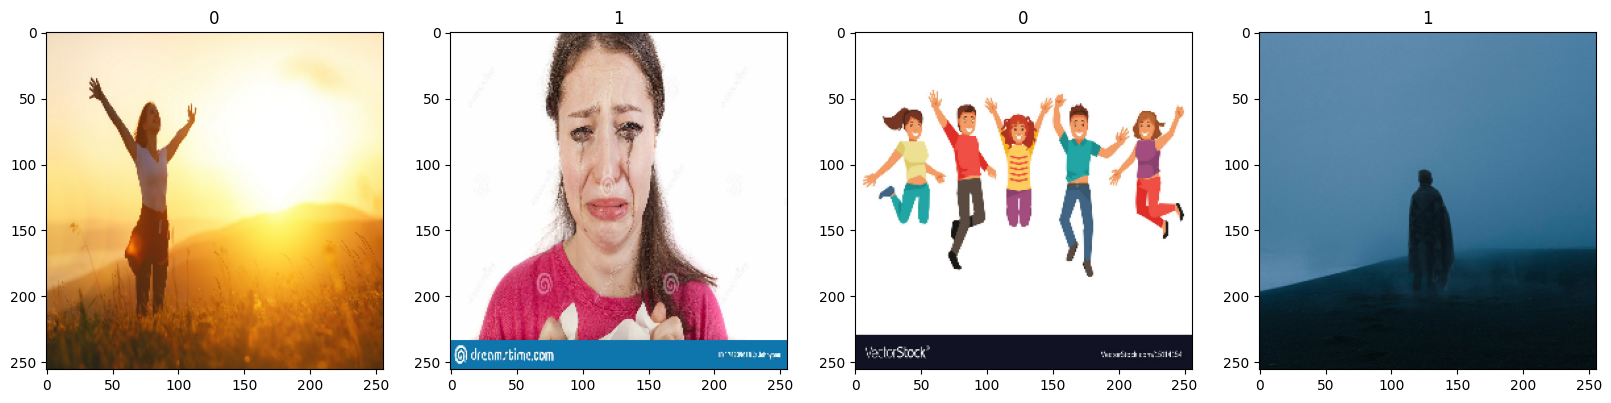

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [15]:
data = data.map(lambda x,y: (x/255, y))

In [16]:
data.as_numpy_iterator().next()

(array([[[[0.6509804 , 0.7921569 , 0.85490197],
          [0.6509804 , 0.7924939 , 0.855913  ],
          [0.6509804 , 0.7940257 , 0.86050856],
          ...,
          [0.2489277 , 0.35481006, 0.437163  ],
          [0.24739583, 0.3532782 , 0.43563113],
          [0.24705882, 0.3529412 , 0.43529412]],
 
         [[0.65401345, 0.7948529 , 0.8586091 ],
          [0.65372384, 0.79492927, 0.85927254],
          [0.6524074 , 0.79527634, 0.8622884 ],
          ...,
          [0.25043634, 0.35631868, 0.43867165],
          [0.24877283, 0.35465518, 0.43700814],
          [0.24840686, 0.3542892 , 0.43664217]],
 
         [[0.66780025, 0.80710787, 0.87545955],
          [0.6661942 , 0.8059994 , 0.8745433 ],
          [0.6588939 , 0.800961  , 0.87037855],
          ...,
          [0.25729382, 0.36317617, 0.4455291 ],
          [0.25503194, 0.3609143 , 0.44326723],
          [0.2545343 , 0.36041668, 0.44276962]],
 
         ...,
 
         [[0.68517154, 0.57144606, 0.5910539 ],
          [0.67849

# 5. Split Data

In [17]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [18]:
train_size

7

In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [20]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [22]:
model = Sequential()

In [23]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [26]:
logdir='logs'

In [27]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [28]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.5395 - loss: 2.2841 - val_accuracy: 0.5000 - val_loss: 0.8080
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.5417 - loss: 0.7604 - val_accuracy: 0.6094 - val_loss: 0.6842
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.5883 - loss: 0.6879 - val_accuracy: 0.8125 - val_loss: 0.6719
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.6734 - loss: 0.6711 - val_accuracy: 0.8438 - val_loss: 0.6295
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - accuracy: 0.8017 - loss: 0.6212 - val_accuracy: 0.8125 - val_loss: 0.4980
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.7030 - loss: 0.5640 - val_accuracy: 0.6250 - val_loss: 0.5051
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.7068 - loss: 0.4930 - val_accuracy: 0.8438 - val_loss: 0.4638
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.6936 - loss: 0.5529 - val_accuracy: 0.9062 - val_loss: 0.4102
Epoch 9/

# 8. Plot Performance

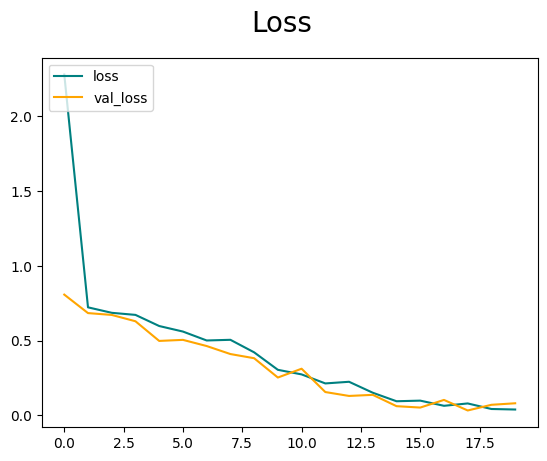

In [29]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

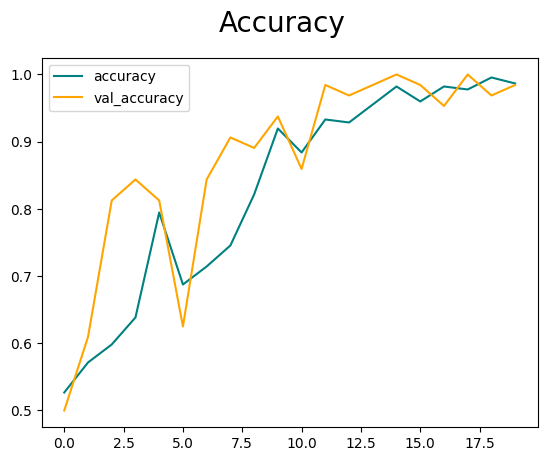

In [30]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [31]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [32]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [33]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


In [34]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [35]:
import cv2

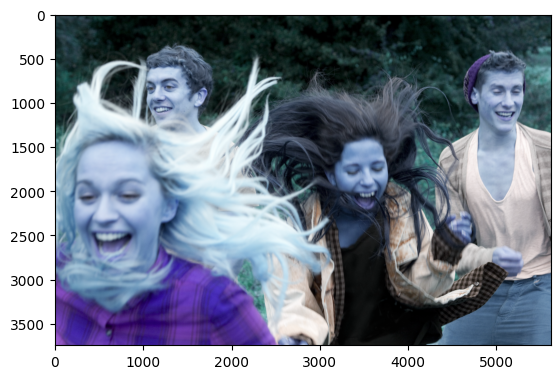

In [36]:
img = cv2.imread('154006829.jpg')
plt.imshow(img)
plt.show()

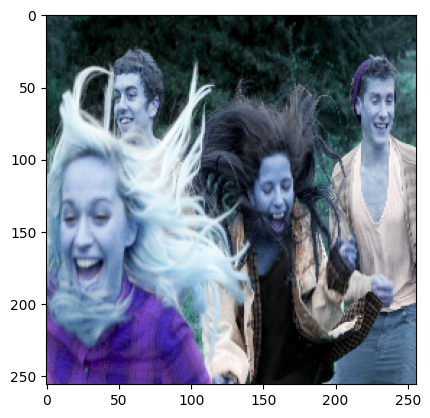

In [37]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [38]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


In [39]:
yhat

array([[0.10672898]], dtype=float32)

In [40]:
if yhat > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [41]:
from tensorflow.keras.models import load_model

In [42]:
model.save(os.path.join('models','imageclassifier.h5'))

In [45]:
new_model = load_model(os.path.join('models','imageclassifier.h5'))

In [46]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


array([[0.10672898]], dtype=float32)

In [55]:
# Assuming `data` is your TensorFlow dataset
for batch in data.take(1):
    print("Batch size:", batch[0].shape[0])

Batch size: 32


In [57]:
from sklearn.metrics import f1_score
import numpy as np

# Assuming `model` is your trained model and `test_data` is your test dataset
# Step 1: Get predictions and true labels
y_true = []
y_pred = []

# Iterate over the test dataset to get predictions
for batch in test:
    X, y = batch  # Unpack features and labels
    predictions = model.predict(X)
    y_true.extend(y)
    y_pred.extend(np.argmax(predictions, axis=1))  # For multi-class classification
    # Use `np.round(predictions)` for binary classification

# Step 2: Calculate the F1 score
f1 = f1_score(y_true, y_pred, average='weighted')  # 'weighted' for multi-class
print("Final F1 Score:", f1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
Final F1 Score: 0.3351564177822321


In [58]:
from tensorflow.keras.metrics import Precision, Recall

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # or 'categorical_crossentropy' for multi-class
    metrics=[Precision(), Recall()]
)

In [61]:
history = model.fit(train, validation_data=val, epochs=10)
print("Final Precision:", history.history['precision'][-1])
print("Final Recall:", history.history['recall'][-1])

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - loss: 0.2087 - precision_1: 0.9715 - recall_1: 0.9048 - val_loss: 0.1251 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - loss: 0.1332 - precision_1: 1.0000 - recall_1: 0.9651 - val_loss: 0.1063 - val_precision_1: 1.0000 - val_recall_1: 0.9714
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - loss: 0.0829 - precision_1: 0.9909 - recall_1: 0.9876 - val_loss: 0.1475 - val_precision_1: 1.0000 - val_recall_1: 0.8684
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - loss: 0.0513 - precision_1: 0.9856 - recall_1: 0.9603 - val_loss: 0.0315 - val_precision_1: 1.0000 - val_recall_1: 0.9706
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - loss: 0.0249 - precision_1: 0.9912 - recall_1: 0.9934 - val_loss: 0.0075 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - loss: 0.0274 - precision_1: 1.0000 - recall_1: 0.9798 - val_loss: 0.0420 - val_precision_1

KeyError: 'precision'